# Projeto Final da Disciplina Fundamentos de Big Data

**Aluna:** Isabella Calfa Vieira Costa

## Inicialização do projeto

In [191]:
# Bibliotecas:
## Pyspark:
import pyspark 
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, when, count, isnan
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier,NaiveBayes
from pyspark.ml.feature import StringIndexer,OneHotEncoder,VectorAssembler,StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Outras libs:
import os
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

## Gráficos:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib

In [139]:
# Criando sessão pyspark:
MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY) \
        .set("spark.maxResultSize", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("test") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

In [129]:
# Variáveis de ambiente (salvar figuras):
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "graficos")
os.makedirs(IMAGES_PATH, exist_ok=True)

## Baixando banco de dados e associando ao Spark

In [130]:
# Importando o dataset:
df = spark.read.csv('datasets/drug.csv', header = True, inferSchema = True)

In [131]:
# Visualização dos tipos de dados importados:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bp: string (nullable = true)
 |-- cholesterol: string (nullable = true)
 |-- Na_to_K: double (nullable = true)
 |-- drug: string (nullable = true)



Campos:
1. Age: Idade
2. Sex: Gênero
3. Bp: Pressão do Sangue (Blood Pressure Levels)
4. Cholesterol: Nível do colesterol
5. Na_to_K: Proporção de Sódio por Potássio
6. Drug: Remédio (droga) utilizada 

In [132]:
# Visualização dos dados:
df.show(5)

+---+---+------+-----------+-------+-----+
|age|sex|    bp|cholesterol|Na_to_K| drug|
+---+---+------+-----------+-------+-----+
| 23|  F|  HIGH|       HIGH| 25.355|drugY|
| 47|  M|   LOW|       HIGH| 13.093|drugC|
| 47|  M|   LOW|       HIGH| 10.114|drugC|
| 28|  F|NORMAL|       HIGH|  7.798|drugX|
| 61|  F|   LOW|       HIGH| 18.043|drugY|
+---+---+------+-----------+-------+-----+
only showing top 5 rows



## Criando duas figuras e uma tabela resumo e interpretando os dados

In [133]:
# Descrição do df:
df.describe().toPandas()

,summary,age,sex,bp,cholesterol,Na_to_K,drug
0,count,200,200,200,200,200,200
1,mean,44.315,None,None,None,16.08448499999999,None
2,stddev,16.544314634751974,None,None,None,7.223955528459517,None
3,min,15,F,HIGH,HIGH,6.269,drugA
4,max,74,M,NORMAL,NORMAL,38.247,drugY


O conjunto de dados escolhido tem 200 linhas com os dados e 6 colunas com as variáveis de análise. Duas das variáveis (age e Na_to_K) são numéricas e as demais categóricas.  

Sobre as variáveis numéricas:  
1. **age:** A idade dos participantes do estudo varia entre 15 e 74 anos, mas em média fica nos 44 anos.
2. **Na_to_K:** A variável tem amplitude entre 6,2% e 3,8% e em média os participantes tem 7,2%

In [134]:
# Verificando os valores das variáveis:
def exploracaoVariavel(coluna):
    print(f'Coluna {coluna}:')
    valoresDistintos = df.select(coluna).distinct().collect()
    print(f'Valores distintos: {valoresDistintos}')
    valoresVazios = df.where(col(coluna).isNull()).count()
    print(f'Valores vazios: {valoresVazios}')
    print()

## Categóricas:
exploracaoVariavel('sex')
exploracaoVariavel('bp')
exploracaoVariavel('cholesterol')
exploracaoVariavel('drug')
## Numéricas:
print(f'Coluna age:')
valoresVazios = df.where(isnan('age')).count()
print(f'Valores vazios: {valoresVazios}')
print()
print(f'Coluna Na_to_K:')
valoresVazios = df.where(isnan('Na_to_K')).count()
print(f'Valores vazios: {valoresVazios}')

Coluna sex:
Valores distintos: [Row(sex='F'), Row(sex='M')]
Valores vazios: 0

Coluna bp:
Valores distintos: [Row(bp='HIGH'), Row(bp='LOW'), Row(bp='NORMAL')]
Valores vazios: 0

Coluna cholesterol:
Valores distintos: [Row(cholesterol='HIGH'), Row(cholesterol='NORMAL')]
Valores vazios: 0

Coluna drug:
Valores distintos: [Row(drug='drugC'), Row(drug='drugA'), Row(drug='drugY'), Row(drug='drugB'), Row(drug='drugX')]
Valores vazios: 0

Coluna age:
Valores vazios: 0

Coluna Na_to_K:
Valores vazios: 0


Sobre as variáveis categóricas:
1. **sex:** Os participantes do estudo se identificavam como sexo masculino ou feminino e não tivemos valores vazios.
2. **bp:** A pressão do sangue pode assumir três graduações: baixa, normal ou alta.
3. **cholesterol:** O colesterol dos participantes ou estava em nível normal ou em nível alto.
4. **drug:** Existem 5 tipos de remédios que podem ser utilizados pelos participantes, conforme descrito.

Text(0.5, 1.0, 'Quantidade x Remédio (droga)')

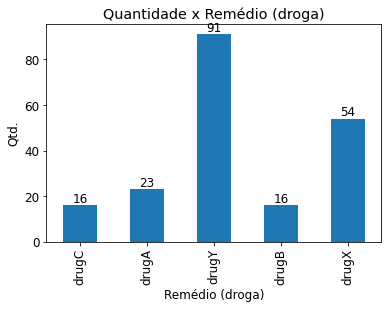

In [135]:
# Visualização do uso dos remédios (drogas):
drug_rank_df = df.select(df.drug).groupBy(df.drug).count().toPandas()

## Gráfico:
ax = drug_rank_df.plot.bar(x='drug',y='count',legend=False)
ax.set_ylabel('Qtd.')
ax.set_xlabel('Remédio (droga)')
ax.bar_label(ax.containers[0])
plt.title('Quantidade x Remédio (droga)')

A droga Y é a mais utilizada pelos participantes do estudo, seguida da droga X.

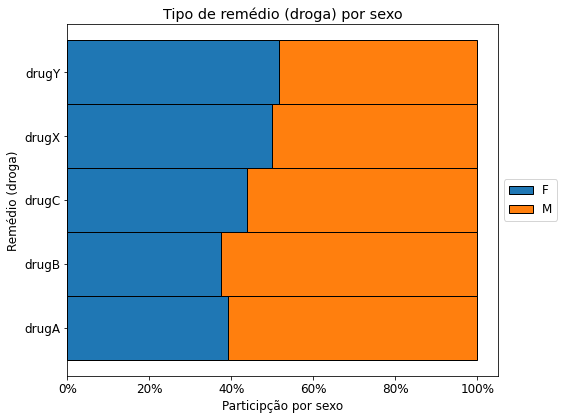

In [137]:
# Avaliação de Remédios por Sexo:
drug_by_sex_df = df.groupBy('drug', 'sex').count().toPandas()

## Gráfico:
fig = plt.figure(figsize=(8, 6))
grid_size = (1,1)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = drug_by_sex_df.groupby(['drug', 'sex']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1  
                , edgecolor='black', ax=ax, title='Tipo de remédio (droga) por sexo')
ylabel = plt.ylabel('Remédio (droga)')
xlabel = plt.xlabel('Participção por sexo')
legend = plt.legend(
    sorted(drug_by_sex_df['sex'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 12})
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter())
a = fig.tight_layout()
plt.show()

As drogas A, B e C são utilizadas predominantemente por homens, enquanto as drogas X e Y tem distribuição mais igualitárias entre homens e mulheres.

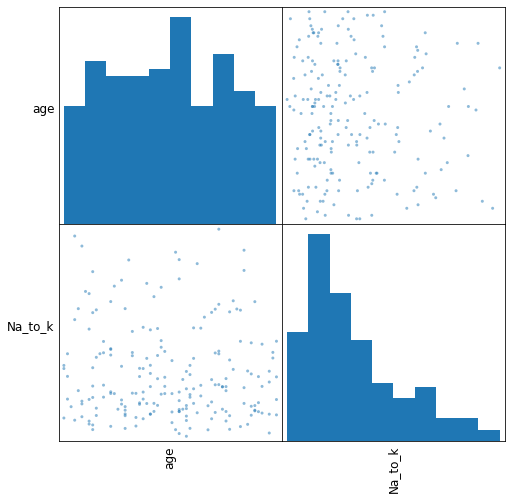

In [149]:
# Correlação entre as variáveis:               
numeric_data = df.select('age','Na_to_k').toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## Utilizando uma técnica e interpretando o resultado

In [175]:
# Convertendo variáveis categóricas em numéricas:
sexIndexer = StringIndexer(inputCol = 'sex',outputCol='sexIndexer')
sexEncoder = OneHotEncoder(inputCol = 'sexIndexer',outputCol = 'sexEncoder')
bpIndexer = StringIndexer(inputCol = 'bp',outputCol='bpIndexer')
bpEncoder = OneHotEncoder(inputCol = 'bpIndexer',outputCol = 'bpEncoder')
cholesterolIndexer = StringIndexer(inputCol = 'cholesterol',outputCol='cholesterolIndexer')
cholesterolEncoder = OneHotEncoder(inputCol = 'cholesterolIndexer',outputCol = 'cholesterolEncoder')
drugIndex = StringIndexer(inputCol = 'drug',outputCol='drugIndex')
indexed = drugIndex.fit(df).transform(df)

## Verificar os dados:
indexed.show(3)
indexed.printSchema()

+---+---+----+-----------+-------+-----+---------+
|age|sex|  bp|cholesterol|Na_to_K| drug|drugIndex|
+---+---+----+-----------+-------+-----+---------+
| 23|  F|HIGH|       HIGH| 25.355|drugY|      0.0|
| 47|  M| LOW|       HIGH| 13.093|drugC|      4.0|
| 47|  M| LOW|       HIGH| 10.114|drugC|      4.0|
+---+---+----+-----------+-------+-----+---------+
only showing top 3 rows

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bp: string (nullable = true)
 |-- cholesterol: string (nullable = true)
 |-- Na_to_K: double (nullable = true)
 |-- drug: string (nullable = true)
 |-- drugIndex: double (nullable = false)



In [176]:
# Definição das variáveis de análise:
assembler = VectorAssembler(inputCols=['age','sexEncoder','bpEncoder','cholesterolEncoder','Na_to_K'], outputCol='features')
sc = StandardScaler(inputCol = "features",outputCol = "standardFeatures")

In [195]:
# Modelos de Classificação:
## Árvore de decisão:
ad = DecisionTreeClassifier(featuresCol='standardFeatures',labelCol='drugIndex')
pip1 = Pipeline(stages = [sexIndexer,sexEncoder,bpIndexer,bpEncoder,cholesterolIndexer,cholesterolEncoder,assembler,
                                 sc,
                                 ad])

## Florestas aleatórias:
fa = RandomForestClassifier(featuresCol='standardFeatures',labelCol='drugIndex')                               
pip2 = Pipeline(stages = [sexIndexer,sexEncoder,bpIndexer,bpEncoder,cholesterolIndexer,cholesterolEncoder,assembler,
                                 sc,
                                 fa])      

## Naive Bayes:                                                            
nb = NaiveBayes(featuresCol='standardFeatures',labelCol='drugIndex')                               
pip3 = Pipeline(stages = [sexIndexer,sexEncoder,bpIndexer,bpEncoder,cholesterolIndexer,cholesterolEncoder,assembler,
                                 sc,
                                 nb])                                                                   

In [199]:
# Aplicando os modelos:
## Divisão em treino e teste:
train,test = indexed.randomSplit([0.7,0.3], seed=2)

## Métrica de Avaliação:
evaluation_metric = MulticlassClassificationEvaluator(predictionCol = 'prediction', labelCol = 'drugIndex')

## Testes dos Modelos:
def modelos(pipeline):
    model = pipeline.fit(train)
    result = model.transform(test)
    predTarget = model.transform(indexed).select('drugIndex','prediction')
    acc=evaluation_metric.evaluate(predTarget,{evaluation_metric.metricName: "accuracy"})
    return acc

## Resultados:
acur=modelos(pip1)
print(f'Acurácia da Árvore de Decisão: {acur}')
acur=modelos(pip2)
print(f'Acurácia da Floresta Aleatória: {acur}')
acur=modelos(pip3)
print(f'Acurácia da Naive Bayes: {acur}')

Acurácia da Árvore de Decisão: 0.99
Acurácia da Floresta Aleatória: 0.985
Acurácia da Naive Bayes: 0.55


Foram utilizados três modelos para tentar classificar qual a droga utilizada conforme as informações do paciente: Árvore de Decisão, Floresta Aleatória e Naive Bayes. Os modelos de Árvore de Decisão e Floresta Aleatória tem acurácia muito parecida e próxima de 1 (máximo), enquando o de Naive Bayes tem acurárcia baixa e seria prontamente descartado. No caso em análise, prefere-se utilizar o modelo de Árvore de Decisão pela acurácia levemente superior.

## Referências

Foram utilizadas as seguintes referências para o trabalho:  
[How to use pyspark to machine learning project](https://towardsdatascience.com/how-to-use-pyspark-for-your-machine-learning-project-19aa138e96ec)  
[Exploratory data analysis with pyspark on databricks](https://towardsdatascience.com/exploratory-data-analysis-eda-with-pyspark-on-databricks-e8d6529626b1)  
[Machine learning with pyspark and mllib](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)  
[Drug Classification Dataset](https://www.kaggle.com/datasets/prathamtripathi/drug-classification)  
[Advanced pyspark for exploratory analysis](https://www.kaggle.com/code/tientd95/advanced-pyspark-for-exploratory-data-analysis/notebook#5.-Explolatory-Data-analysis-)  
[Exploratory Data Analysis](https://www.kaggle.com/code/tientd95/advanced-pyspark-for-exploratory-data-analysis/notebook#5.-Explolatory-Data-analysis-)